# XGBOOST

## LIBRARIES

In [16]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

## DATASET

In [17]:
# Import dataset
location_holidays = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\holidays_events.csv"
holidays = pd.read_csv(location_holidays, parse_dates=['date'])
location_oil = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\oil.csv"
oil = pd.read_csv(location_oil, parse_dates=['date'])
location_stores = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\stores.csv"
stores = pd.read_csv(location_stores)
location_transactions = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\transactions.csv"
transactions = pd.read_csv(location_transactions, parse_dates=['date'])
location_train = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\train.csv"
train = pd.read_csv(location_train, parse_dates=['date'])
location_test = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\test.csv"
test = pd.read_csv(location_test, parse_dates=['date'])

In [18]:
#Join train and holidays
df = pd.merge(train, holidays.drop(columns=['locale_name', 'description']),
               how='left', on=['date'])
#Replace NaN values in 'type', 'locale' and 'transferred' column with 'No-holiday'
df['type'] = df['type'].fillna('No-holiday')
df['locale'] = df['locale'].fillna('No-holiday')
df['transferred'] = df['transferred'].fillna('No-holiday')
#Join df and oil
df = pd.merge(df, oil, how='left', on=['date'])
#Join df and stores
df = pd.merge(df, stores, how='left', on=['store_nbr'])

## TRAIN 80 TEST 20

In [19]:
#Divide df into train and validation
train_size = int(len(df)*0.8)
df_80, df_20 = df[:train_size], df[train_size:]

## DEFINE X_TRAIN (80%), Y_TEST

In [20]:
#Create a pipeline to pre process X_train
def preprocess_data(X):
    #Separate date column in day, month and year
    X['day'] = X['date'].dt.day
    X['month'] = X['date'].dt.month
    X['year'] = X['date'].dt.year
    #Drop date column
    X = X.drop(columns=['date'])
    #Tranform object variables to categorical
    for col in ['family', 'type_x', 'locale', 'transferred']:
        X[col] = X[col].astype('category')
    return X

In [21]:
#Initialize Y_train and X_train
Y_train = None
X_train = None
#Define Y as sales
Y_train = df_80['sales']
#Define X as all columns except 'sales'
X_train = df_80.drop(columns=['sales','id','store_nbr','onpromotion','city','state','type_y'])
#Pre process X_train
X_train = preprocess_data(X_train)

## TRAIN MODEL

In [ ]:
#Train XGBoost model
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1,enable_categorical=True)
model_xgb.fit(X_train, Y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


## PREDICT X_TEST(20%)

In [23]:
#Predict sales for df_20
X_test = df_20.drop(columns=['sales','id','store_nbr','onpromotion','city','state','type_y'])
#Pre process X_test
X_test = preprocess_data(X_test)
#Predict sales
Y_pred = model_xgb.predict(X_test)
#Replace negative predictions with 0
Y_pred = np.where(Y_pred < 0, 0, Y_pred)

## RESULTS

In [ ]:
#Print RMSE, MAE, MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(df_20['sales'], Y_pred)
print("MAE: %f" % (mae))
mape = mean_absolute_percentage_error(df_20['sales'], Y_pred)
print("MAPE: %f" % (mape))
rmse = np.sqrt(mean_squared_error(df_20['sales'], Y_pred))
print("RMSE: %f" % (rmse))
# RMSE: 563.562761, objective='reg:squarederror', n_estimators=1000, learning_rate=0.1,enable_categorical=True
# RMSE: 564.280162, objective='reg:squarederror', n_estimators=10000, learning_rate=0.01,enable_categorical=True

MAE: 154.650061
MAPE: 52434706783493968.000000
RMSE: 564.280162


Text(0, 0.5, 'Predicted Sales')

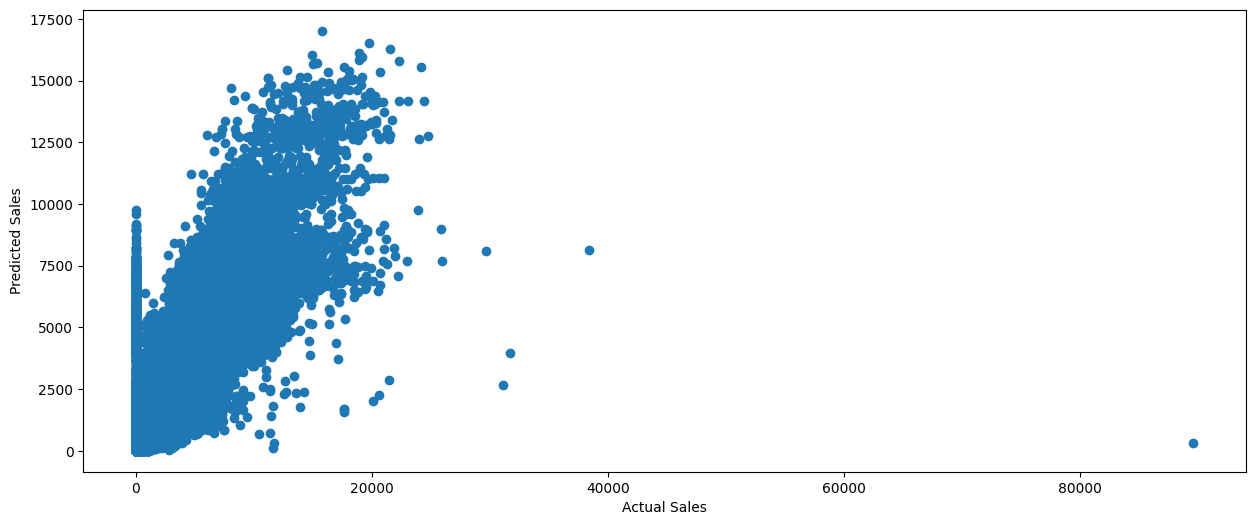

In [25]:
#Plot predicted sales vs actual sales
plt.figure(figsize=(15, 6))
plt.scatter(df_20['sales'], Y_pred)
#Show axes names
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

In [26]:
df_20['sales_pred'] = Y_pred
#Residuals
df_20['residuals'] = df_20['sales'] - df_20['sales_pred']

C:\Users\75558\AppData\Local\Temp\ipykernel_12480\3473065934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_20['sales_pred'] = Y_pred
C:\Users\75558\AppData\Local\Temp\ipykernel_12480\3473065934.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_20['residuals'] = df_20['sales'] - df_20['sales_pred']


Text(0.5, 1.0, 'Residuals for family: BABY CARE before 2019-01-01')

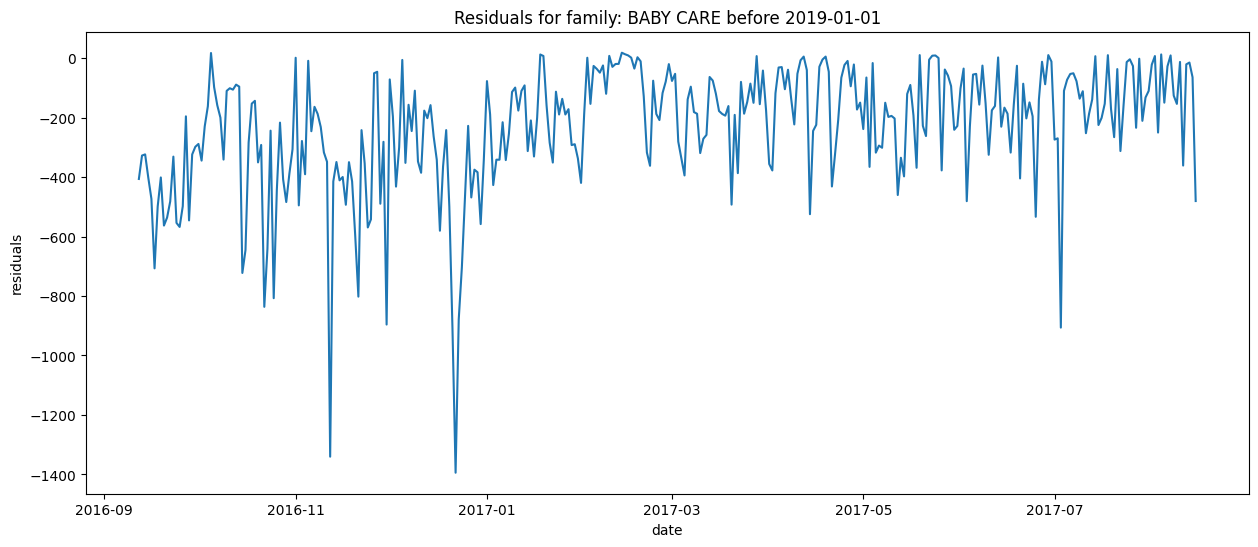

In [27]:
#Time series by family with residuals
#Group by date and family, sum residuals
df_family_20 = None
df_family_20 = df_20.groupby(['date', 'family']).agg({'residuals': 'sum'}).reset_index()
#Filter df_family_20 for 'family' = '' for dates < 
family_list = df_family_20['family'].unique()
fam=family_list[1]
dates= '2019-01-01'
df_family_20_filtered = df_family_20[(df_family_20['family'] == fam) & (df_family_20['date'] < dates)]
#Plot sales for '' family
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_family_20_filtered, x='date', y='residuals')
#Title family
plt.title(f'Residuals for family: {fam} before {dates}')

In [28]:
#FEATURE IMPORTANCE
importances = model_xgb.feature_importances_
#Sort importances in descending order
indices = np.argsort(importances)[::-1]
#Print feature ranking
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X_train.columns[indices[f]]} ({importances[indices[f]]})")

1. feature family (0.4232720136642456)
2. feature year (0.184000626206398)
3. feature cluster (0.1807975172996521)
4. feature dcoilwtico (0.06820116937160492)
5. feature month (0.0545017346739769)
6. feature locale (0.044682927429676056)
7. feature type_x (0.02344033122062683)
8. feature day (0.01581558957695961)
9. feature transferred (0.0052880351431667805)


In [ ]:
## NEXT STEPS: VISUALIZE DIFFERENCE BETWEEN PREDICTED AND ACTUAL SALES FOR EACH FAMILY OVER TIME
